# Lesson 2

In [1]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from fastai import fastai
from fastai.fastai import transforms
from fastai.fastai import conv_learner
from fastai.fastai import model
from fastai.fastai import dataset
from fastai.fastai import sgdr
from fastai.fastai import plots as faplots
from fastai.fastai import metrics
from torchvision.models import resnet18, resnet34
from fastai.fastai.torch_imports import resnext101_64
import torch

## 00:00 - Last week's recap

* Trained image classifier using 3 lines of code.
* Images were stored in a data structure with a class of images per folder.
  * One of two common ways to provide data for deep learning problems.
* Looked at analysing results.
* Briefly looked at the *practise* of picking a learning rate; more theory to come.

## 00:04:55 - Learning rate revisited

* Idea of learning rate: thing that's going to hone in on the solution.
* What if you are trying to fit to some function? aka: find the minimum point of a function.
  * Pick some random point, then find the gradient: "how steep is it at this point?"
  * Then multiple that by the learning rate aiming to take a step in the direction of the minima.
* Learning rate too small? Too slow to converge.

<img src="https://i.gyazo.com/bba25d4acc2ed2c579a8cbc04bfd2c2c.gif" width="400px">
  
* Learning rate too big? Over step the minima.

<img src="https://i.gyazo.com/b9ce5aabf8a8407930b2e160e5d349a2.gif" width="400px">
  
* Would be nice if you had a thing that just told you what is the best learning rate.

## 00:07:30 - Learning rate finder

* Works as follows:
  * Each time we look at a mini-batch of images, we increase the learning rate.
  * Look at the plot of learning rate vs loss.
    * Look at the point just before the loss is at the lowest and go back 1 order of magnitude, as this gif highlights:
      
<img src="https://i.gyazo.com/4bc41b77588e02768d547b129362d104.gif" width="400px">
      
* This is the only "hyperparameter" you need to adjust when using the Fast.AI library.
  * Setting learning rates used to be considered hard and "fiddly".
    
## 00:08:38 - Scientific notation

* $10^{-1}$ = 0.1 = `1e-1`
* $10^{-2}$ = 0.01 = `1e-2`
* $10^{-3}$ = 0.001 = `1e-3`
* Note that the negative value is equal to the number of digits after the decimal place.

## 00:12:38 - Audience questions

* Question 1: Why does this learning rate selection method work vs something else like Momentum?
* Answer 1: Learning rate selection is orphonganal to the choice of optimization algorithm (covered later). It finds the best learning rate for your algorithm.

* Question 2 (00:14:05): When you use optimizers like Adam which uses adaptive learning rates, are there any issues setting learning rates like this?
* Answer 2: Basic answer: no. Even with Adam, which uses "dynamic learning rates" there is a value to set called the learning rate and this technique can apply.

## 00:15:00 - Data augmentation

* Models have 100s of millions of params and training them for long enough can cause overfitting.
  * Best thing you can do to avoid this is to give it more data.
* One approach to getting more data is data augmentation.
  * Data augmentation is simply a set of transforms like flipping horizontally, skewing, randomly cropping etc that can give the model the illusion of more data.
* To use data augmentations in Fast.AI library, pass the `aug_tfms` argument to `tfms_from_model` which is a list of transforms to perform randomly on the data.

In [74]:
PATH = 'data/dogscats'
arch = resnet34
sz = 224

In [3]:
tfms = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)

* Easiest way to understand augmentations is to look at some examples of them:

In [4]:
def get_augs():
    data = dataset.ImageClassifierData.from_paths(PATH, tfms=tfms)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [5]:
ims = np.stack([get_augs() for i in range(6)])

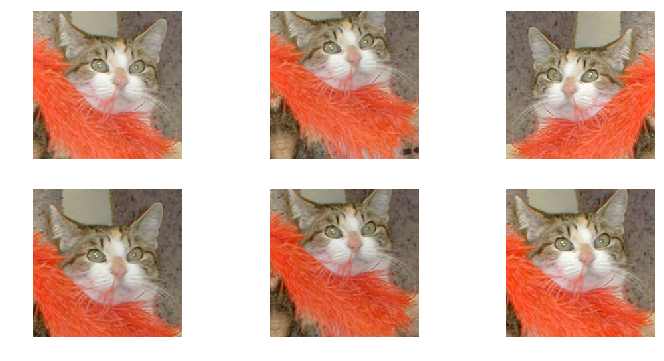

In [6]:
faplots.plots(ims, rows=2)

* Need to consider the right augmentations for your dataset.
  * `transforms_side_on` would be best for images generally taken from the side.
    * For cat photos, you probably wouldn't want to flip them vertically.
  * `transforms_top_down` may be better for images taken from the top, ie satellite imagery.

## 00:18:54 - Audience questions about learning rate finder

* Question 1: Why do we use the learning rate that's less than the lowest point?
* Answer 1: Want to find learning rate that's most likely to find the minimum. The one at the lowest point might jump close to the minimum, but will likely overshoot. The one just before that, should walk quickly to the minimum.

* Question 2: Do we need to find the best learning rate each epoch?
* Answer 2: Jeremy usually runs it once when it starts. If he unfreezes layers (covered later), he may run it again. Basically: if you change something in your model or how you train it, you'd rerun the finder.

## 00:24:10 - Data augmentations continued

* As well as the main two transformation lists, can create custom transform lists (covered later).
* When doing data aug, we are saying: "Based on our domain knowledge, here are different ways we can mess with the image and still understand what's in it".
* Now, when training the model, we can pass in the transforms:

In [8]:
data = dataset.ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

In [9]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.046287   0.02588    0.990234  



[0.025879795, 0.990234375]

* Initially, they won't do anything because of the `precompute=True` argument.
  * What it's doing:
    1. Caching the activations (a number) for every image: "precomputed activations".
    2. Now, we can use those cached values to speed up future epochs.
* In order to do it, need to set the precomputed to False:

In [10]:
learn.precompute = False

In [11]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.055033   0.025478   0.989746  
    1      0.037407   0.025497   0.990234                     
    2      0.043661   0.02586    0.991211                     



[0.025859684, 0.9912109375]

## 00:30:17 - Stochastic Gradient Descent with Restarts (SGDR)

* In the above example, we added `cycle_len=1` which enables a technique called *Stochastic Gradient Descent with Restarts*, which is a variant of *learning rate annealing*.
* Basic idea: as you get closer to the minima, you want to decrease your learning rate to ensure you get as close as possible to the minimum: called learning rate annealing.
* Standard approach is to pick a learning rate that works okay. Then, when your training stops improving, just decrease it.
* Better approach: pick some functional form for your learning rate, like a line or, even better, one half of a cosine curve.
  * At the top of the curve, when you are not very close, you have a high learning rate.
  * Then, as your training progresses, your rate starts to decrease quite rapidly.
  
    <img src="https://i.gyazo.com/0e3f9f1c7ab24dbd08c691ff725df903.gif" width=400px>

  * Called "cosign annealing".
* Because there can be lots of local minimas in high dimensional space, one approach is to have a learning rate that "jumps" occasionally.
  * This can get you out of a local minima, to the global minima.

## 00:35:40 - Audience questions about SGDR

* Question 1: Could you get the same effect (as cosign annealing) by training multiple models with different random initialisations, with the expectation that most of them will eventually explore the global minima?
* Answer 1: Before SGDR, people used to create ensembles, which is basically that approach. The advantage to SGDR, is that once you've found the local minima, you tend to hang around it, even if your learning rate increases, so you don't need the ensemble approach so much.
  * SGDR is Jeremy's "superpower"; usually gets him great results on Kaggle competitions.
  * Picking a reasonably high LR is a good idea, because you know the cosign annealing will gradually reduce the LR.
  
* Question 2: How many times do you change the learning rate per epoch?
* Answer 2: Learning rate is changed on each mini batch. Number of times it's reset, is defined by the `cycle_len` param. A value of 1 == one epoch, see below:

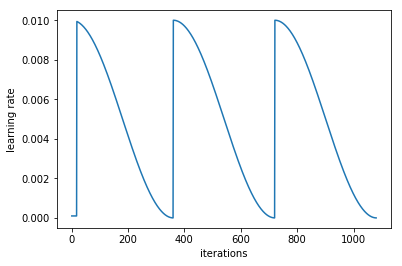

In [12]:
learn.sched.plot_lr()

* Question 3: Could you explain `precompute=True` - still confusing?
* Answer 3: Will be revisited later in the course.

* Question 4: Our main goal is to generalise. Are we keeping track of the minimas and averaging them or something?
* Answer 4: You could take the averages of the losses at each point where the learning rate is the lowest, but we're not doing that yet.
  * You could add `cycle_save_weights` param, which saves the weights at the end of each cycle for ensembling.

## 00:40:34 - Saving weights

* From time-to-time, you should save and load your weight as follows:

In [13]:
learn.save('224_lastlayer')

In [15]:
learn.load('224_lastlayer')

* When you save, create precomputed activations, resizing images, you are creating temporary files.
* Example of the data folder in dogsandcats: 

In [16]:
!ls data/dogscats/

models	sample	test1  tmp  train  valid


  * Note the existance of the `tmp` directory. All precomputed activations go in here.
    * If you are getting weird errors, might be worth deleting your `tmp` directory.

In [17]:
!ls data/dogscats/tmp/

x_act_resnet34_0_224.bc       x_act_test_resnet34_0_244.bc
x_act_resnet34_0_244.bc       x_act_val_resnet34_0_224.bc
x_act_test_resnet34_0_224.bc  x_act_val_resnet34_0_244.bc


  * The `model` directory is where you pretrained models go:

In [19]:
!ls data/dogscats/models/

224_lastlayer.h5  tmp.h5


## 00:42:35 - Audience question about weight caching

* Question 1: If I want to train my model from scratch, do I need to delete the precomputed activations?
* Answer 1: Not really, just create a new learn object - only delete if you have some error.

## 00:43:50 - Finetuning and differential learning rates

* Everything we've done so far hasn't changed the pretrained filter in early stages of network.
* If your pictures are quite different from ImageNet images, you may need to train earlier layers.
* To tell learner to train earlier layers, use `learn.unfreeze()`:

In [11]:
learn.unfreeze()

* Since the earlier layers probably don't need to change much, you most likely want to set a lower learning rate for earlier layers.
  * Can pass an array of learning rates:
    1. Position 1: first few layer learning rates.
    2. Position 2: middle learning layers.
    3. Position 3: added features.

In [12]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.048514   0.026359   0.989258  
    1      0.04       0.025339   0.989746                     
    2      0.029704   0.023698   0.98877                      
    3      0.028045   0.023565   0.991699                     
    4      0.024568   0.02078    0.993652                     
    5      0.02012    0.020977   0.992676                     
    6      0.02126    0.020534   0.992676                     



[0.02053412, 0.99267578125]

  * Doesn't have a name, Fast.ai calls it "differential learning rates".
* Above he's added a param `cycle_mult`, this doubles the length of a "cycle" after each cycle as follows:

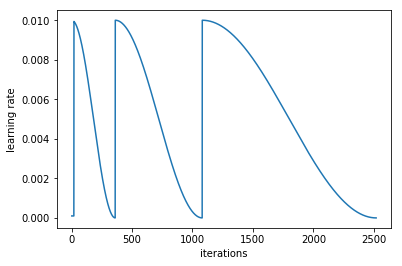

In [24]:
learn.sched.plot_lr()

In [25]:
learn.save('224_all')

In [13]:
learn.load('224_all')

## 00:55:28 - Audience questions on generalisation

* Question 1: Why does smoother surfaces correalte to more generalised networks?
* Answer 1: Idea of generalisation: if you give model a slightly different cat image, it should still predict a cat. The lowest minima should allow for that.

## 00:56:56 - Test time augmentation

* To make the images square, you'll generally just crop out the square in the middle of the image.
  * For some images, this could remove the context required to classify it.
* Solution: after you've trained the model, take 4 random data augmentations and the original image, then do a prediction for all. Take the average of all predictions and return that as the final predictions.
* To do that in Fast.AI, just call `TTA()`:

In [58]:
log_preds, y = learn.TTA()

In [62]:
probs = np.mean(np.exp(log_preds), axis=0)

In [36]:
def accuracy_np(preds, targs):
    preds = np.argmax(preds, 1)
    return (preds==targs).mean()

In [65]:
accuracy_np(probs, y)

0.995

  * TTA by default uses the validation set.

## 01:00:05 - Audience questions

* Question 1: ??
* Answer 1: During training, we aren't using TTA on the validation set.

* Question 2: Is there a high probabilty of having a sample in test time that wasn't seen during training?
* Answer 2: Yes. Every image that was data augmented will most likely be unique due to the number of possible permutations.

* Question 3: Why not use white padding or borders?
* Answer 3: Adding borders hasn't helped much in Jeremy's experiments.
  * Reflection padding can work well for stuff like satellite images.

* Question 4: How do you data augmentation with data that's not images?
* Answer 4: No one seems to know. In NLP, people have tried replacing synoymns, but not a lot of substantial research.

* Question 5: Couldn't you just use a sliding window over the image as an augmentation?
* Answer 5: Probably not useful during training, since you want tonnes of random augmentations. Fixed crops may be better during TTA - Jeremy's hasn't tried much.

* Question 6: Is the Fast.AI library open source?
* Answer 6: Yes. It sits on top of PyTorch, which itself is open source. PyTorch isn't very easy to use for beginners - hence Fast.AI.
  * Some limitations: if you want to do stuff on phones, you'll need to use Tensorflow.
  * Every year, the libraries tend to change. Important to know the concepts vs implementations.
  
* Question 7: Do you have an opinion on Pyro (Uber's new release)?
* Answer 7: Hasn't look at it, but interested in probabilistic programming.

## 01:11:50 - Deeper results analysis

* What does 99.65% accuracy mean?
* Useful to look at confusion matrix:
  * From the actual 1000 cats, how many did we think were dogs (and vice versa for dogs)?

In [76]:
preds = np.argmax(probs, 1)
probs = probs[:,1]

In [77]:
print(preds.shape)
print(probs.shape)

(2000,)
(2000,)


In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  5 995]]


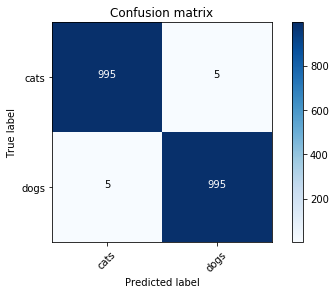

In [72]:
faplots.plot_confusion_matrix(cm, data.classes)

* In the above example, of the 1000 that are dogs, 5 were predicted as cats.
* Let's take a look a the bad predictions:

In [47]:
def plots(imgs, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
            plt.imshow(imgs[i])
    

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)


def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]


def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


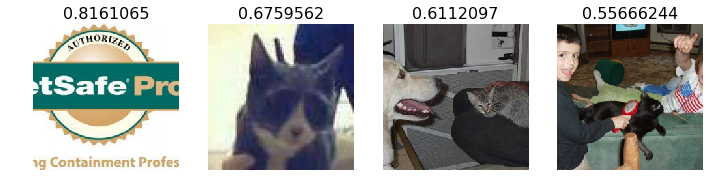

In [79]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect cats')

* Can see the first one isn't even a cat. The second appears to have a lot of artifacts.

Most incorrect dogs


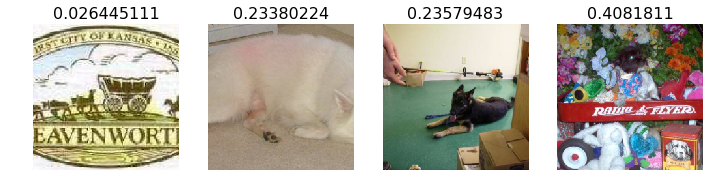

In [80]:
plot_val_with_title(most_by_correct(1, False), 'Most incorrect dogs')

## 01:14:10 - Basic steps to train a world-class image classifier (review)

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
  * If the problem is very different from ImageNet, then maybe want a higher learning rate for the earlier layers.
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting

## 01:16:39 - Walk through of steps on Dog Breed identification

* Firstly, downloading the data from Kaggle (not covered in lecture):

In [2]:
PATH = 'data/dogbreed/'

In [2]:
!kaggle competitions download -c dog-breed-identification --path='{PATH}'

labels.csv.zip: Downloaded 214KB of 214KB
sample_submission.csv.zip: Downloaded 281KB of 281KB
test.zip: Downloaded 346MB of 346MB
train.zip: Downloaded 345MB of 345MB


In [38]:
files = os.listdir(PATH)

In [41]:
for file in files:
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}{file} 

In [43]:
!ls {PATH}

labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


* To get resnext101 working, I had to download the weights file as follows:

```
cd fastai/fastai
wget http://files.fast.ai/models/weights.tgz
tar -xvzf weights.tgz
```

In [66]:
sz = 224
arch = resnext101_64
bs = 58

* Preparing validation indexes (20% of the training data):

In [67]:
label_csv = f'{PATH}labels.csv'

# Get num training rows (excluding the header row)
n = len(list(open(label_csv))) - 1
val_idxs = dataset.get_cv_idxs(n, val_pct=0.2)

In [68]:
val_idxs

array([2882, 4514, 7717, ..., 8922, 6774,   37])

* Initial exploration:

In [69]:
label_df = pd.read_csv(label_csv)

In [70]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


  * Different to cats and dogs, in that all images are in one folder with a provided CSV that has the labels of each image.
* Create a pivot table to group the breeds, then sort by count.

In [71]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


* Start by enabling data augmentation. Since the images are taken side on, we use the `transforms_side_on` set:

In [72]:
tfms = transforms.tfms_from_model(
    arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)

# Note the suffix arg. Required since the filenames in the csv don't include it.
data = dataset.ImageClassifierData.from_csv(
    PATH, 'train', f'{PATH}labels.csv',
    test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

  * Max zoom = when doing the data augmentation, we zoom in up to 1.1x.

In [73]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

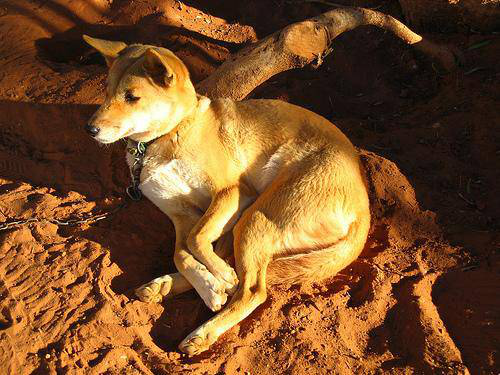

In [74]:
img = Image.open(fn); img

* Want to know how big the images are. If they're huge or tiny, may need some special processing. Not in this case.

In [75]:
img.size

(500, 375)

* Create a dictionary that maps name of the file to the size.

In [76]:
size_d = {k: Image.open(PATH + k).size for k in data.trn_ds.fnames}

* Now plot a histogram of row and column sizes:

In [77]:
row_sz, col_sz = list(zip(*size_d.values()))

In [78]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [79]:
row_sz[:5]

array([500, 500, 500, 500, 500])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

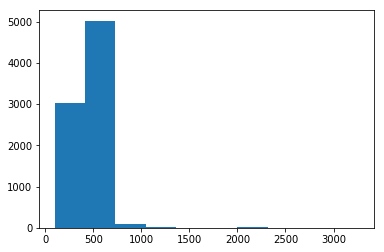

In [80]:
plt.hist(row_sz)

* Can see that some images are > 2k pixels, but majority around 500.
* Let's try a histogram with just the imgs < 1k:

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

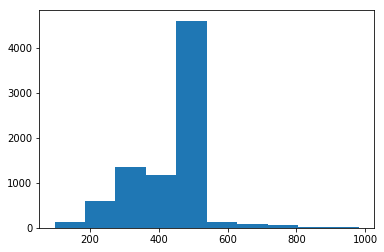

In [81]:
plt.hist(row_sz[row_sz < 1000])

### 01:26:26 - Audience questions - How many items in the val set?

* Question 1: How many images should we have in the validation set? Always 20%?
* Answer 1: If you train the model multiple times and you're getting different results on validation set, you may have a val set that's too small. Depends on the level of accuracy you care about.

In [82]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [83]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

* Appears to be a normal dataset, that you can use standard image classification techniques on.
  * Dogs generally take up the majority of the image, so don't need any special cropping techniques.
* Create a function to load the data, starting with very small images to test out an initial model:

In [84]:
def get_data(sz, bz):
    tfms = transforms.tfms_from_model(
        arch, sz, aug_tfms=transforms.transforms_side_on, max_zoom=1.1)

    data = dataset.ImageClassifierData.from_csv(
        PATH, 'train', f'{PATH}labels.csv',
        test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return dat if sz > 300 else data.resize(340, 'tmp')

In [85]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

* If you get a CUDA out of memory error, you need to restart your Jupyter notebook. You may need to use a smaller batch size in this case: usually just halve the batch size.

In [86]:
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [04:08<00:00,  1.39s/it]


In [87]:
learn.fit(1e-2, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.938538   0.429189   0.907088  
    1      0.436849   0.342118   0.911398                    
    2      0.318193   0.37514    0.90613                     
    3      0.253319   0.271571   0.920019                    
    4      0.206658   0.259173   0.923851                    



[0.25917333, 0.9238505827056037]

* Turn off precomputed activations and run a few more epochs:

In [88]:
learn.precompute = False

In [89]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.249996   0.23399    0.921935  
    1      0.240525   0.235608   0.921935                    
    2      0.216187   0.23032    0.923851                    
    3      0.206011   0.229188   0.921456                    
    4      0.213539   0.226983   0.925766                    



[0.22698334, 0.9257662859227922]

* Remember: epoch = pass through the data, cycle = how every many epochs you said was in a cycle (in this case 1).

In [90]:
learn.save('224_pre')

In [91]:
learn.save('224_pre')

* Try increasing the size of the images.
  * You can call `learn.set_data` and pass in larger images.
* By passing in larger images than the ones trained on, it can often fix overfitting problems and increase performance of the model.

In [92]:
learn.set_data(get_data(299, bs))
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [93]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.22312    0.220355   0.931513  
    1      0.207811   0.216022   0.928161                    
    2      0.186389   0.214734   0.930077                    



[0.21473424, 0.9300766305791007]

### 01:34:43 - Can you do the img resize trick in Keras/TF (audience question)

* Question 1: Can you use the same trick in Keras/TF?
* Answer 1: Worth trying - should work.

* Notice that validation loss is lower than training loss: underfitting.
  * Likely that cycle length is too low: learning rate pops up before it gets a chance to find a minima.
  * Try again with increasing cycle length:

In [94]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.16667    0.214711   0.931034  
    1      0.181358   0.214867   0.927682                    
    2      0.163213   0.211974   0.929598                    
    3      0.170905   0.215063   0.929598                    
    4      0.147727   0.219002   0.928161                    
    5      0.12925    0.21417    0.929598                    
    6      0.118563   0.21363    0.929119                    



[0.21363014, 0.9291187756591373]

* Run TTA. which helps a little:

In [95]:
log_preds, y = learn.TTA()

In [96]:
from sklearn.metrics import log_loss

probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y), log_loss(y, probs)

(0.9305283757338552, 0.2044614408327128)

In [97]:
learn.save('229_pre')

In [98]:
learn.load('229_pre')

* Run a couple more cycles:

In [99]:
learn.fit(1e-2, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.125059   0.216374   0.926245  
    1      0.130774   0.212375   0.926245                    



[0.21237491, 0.9262452158663008]

In [100]:
learn.save('229_pre')

* Didn't try unfreezing, because the dog breed set is actually a subset of ImageNet, so the conv layers are likely to be optimial.

In [101]:
log_preds, y = learn.TTA()

probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y), log_loss(y, probs)

(0.9344422700587084, 0.20300608805239573)

## 01:38:47 - Audience questions 

* Question 1: The dataset isn't balanced, is that a problem?
* Answer 1: It's not unbalanced enough to worry about. If it is was, we'd use a techinque from a recent paper which says to make copies of the rare classes.

* Question 2: Precompute vs unfreeze - what's the difference?
* Answer 2: Precompute is about saving results of activations to speed up training and inference, unfreezing about finetuning those activations.

* Question 3: Is there a shorter, simpler version of the 5 steps?
* Answer 3: Use lr_find, then train last layer, unfreeze all layers, set differential learning rates, then full network with cycle_mult=2.

* Question 4: Does reducing batch size affect the speed of training?
* Answer 4: Yes because you're calculating the gradient with less images, which is less accurate and more volatile: you'll move towards the minima slower. In practise, isn't that much slower.

* Question 5: Asked for more info on the convolution representation from the last lesson.

## 01:48:30 - Improving upon the model

* Increasing the image size can help.
* Use a different architecture.
  * J likes ResNext, which was the 2nd place winner in 2017.
* ResNext
  * Next step after `resnet34` is `resnext50`.
    * Is 2-3 times slower and uses that much more memory too.

## 01:53:00 - Multilabel classification on satellite imagery

In [2]:
PATH = 'data/planet/'

In [103]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space --path='{PATH}'

train-jpg.tar.7z: Downloaded 600MB of 600MB
test-jpg.tar.7z: Downloaded 603MB of 603MB
train-tif-v2.tar.7z: Downloaded 13GB of 13GBGB
test-tif-v2.tar.7z: Downloaded 19GB of 19GBGB
test-jpg-additional.tar.7z: Downloaded 304MB of 304MB
Kaggle-planet-test-tif.torrent: Downloaded 2MB of 2MB
Kaggle-planet-train-tif.torrent: Downloaded 1MB of 1MB
sample_submission_v2.csv.zip: Downloaded 154KB of 154KB
train_v2.csv.zip: Downloaded 159KB of 159KB
test_v2_file_mapping.csv.zip: Downloaded 110KB of 110KB


In [104]:
!ls {PATH}

Kaggle-planet-test-tif.torrent	 test-tif-v2.tar.7z
Kaggle-planet-train-tif.torrent  test_v2_file_mapping.csv.zip
sample_submission_v2.csv.zip	 train-jpg.tar.7z
test-jpg-additional.tar.7z	 train-tif-v2.tar.7z
test-jpg.tar.7z			 train_v2.csv.zip


In [108]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip-full
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 919 kB of archives.
After this operation, 3,959 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu xenial/universe amd64 p7zip-full amd64 9.20.1~dfsg.1-4.2 [919 kB]
Fetched 919 kB in 0s (1,397 kB/s)   

78Selecting previously unselected package p7zip-full.
(Reading database ... 157346 files and directories currently installed.)
Preparing to unpack .../p7zip-full_9.20.1~dfsg.1-4.2_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 16%] [##########................................................] 8Unpacking p7zip-full (9.20.1~dfsg.1-4.2) ...
7Progress: [ 33%] [####################......................................] 87Progress: [ 50%]

In [3]:
files = os.listdir(PATH)

In [7]:
for file in files:
    if file.endswith('zip'):        
        !unzip -o -q -d {PATH} {PATH}{file}
    elif file.endswith('7z'):
        !7z x -so {PATH}{file} | tar xf - -C {PATH}


7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,8 CPUs)

Processing archive: data/planet/train-tif-v2.tar.7z

Extracting  train-tif-v2.tar

Everything is Ok

Size:       21264107520
Compressed: 13815595131

7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,8 CPUs)

Processing archive: data/planet/train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207

7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,8 CPUs)

Processing archive: data/planet/test-jpg.tar.7z

Extracting  test-jpg.tar

Everything is Ok

Size:       668989440
Compressed: 632362315

7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,8 CPUs)

Processing archive: data/planet

### Multi-label vs single-label classification

* In the dogs & cats and dogbreeds datasets, each image is assigned to a single class:

In [19]:
from sklearn.metrics import fbeta_score

import warnings


def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [20]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In [21]:
dc_path = f'data/dogscats/valid/'
list_paths = [get_1st(f'{dc_path}cats'), get_1st(f'{dc_path}dogs')]

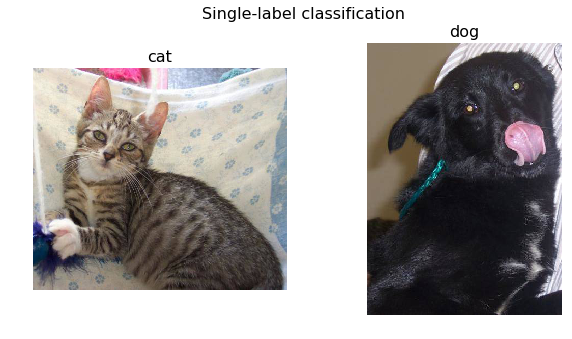

In [22]:
faplots.plots_from_files(list_paths, titles=['cat', 'dog'], maintitle='Single-label classification')

* In the planet dataset, each image can have multiple classes:

In [23]:
list_paths = [f'{PATH}train-jpg/train_0.jpg', f'{PATH}train-jpg/train_1.jpg']

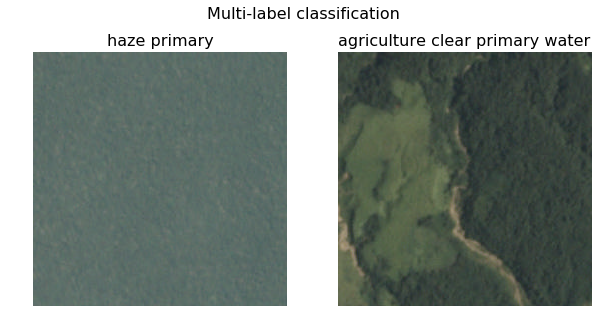

In [24]:
titles = ['haze primary', 'agriculture clear primary water']
faplots.plots_from_files(list_paths, titles=titles, maintitle='Multi-label classification')

### Multi-label models for Planet dataset

In [26]:
metrics = [f2]
f_model = resnet34

In [28]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) - 1
val_idxs = dataset.get_cv_idxs(n)

* Note that in the below `get_data` call, we're using `transforms_top_down` to allow vertical flips.

In [29]:
def get_data(sz):
    tfms = transforms.tfms_from_model(
        f_model, sz, aug_tfms=transforms.transforms_top_down, max_zoom=1.05)
    return dataset.ImageClassifierData.from_csv(
        PATH, 'train-jpg', label_csv, tfms=tfms,
        suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [30]:
sz = 64

In [31]:
data = get_data(sz)

In [33]:
data = data.resize(int(sz * 1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [34]:
learn = conv_learner.ConvLearner.pretrained(f_model, data, metrics=metrics)

* Figure out the best learning rate:

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.216449   0.23652    0.83978   



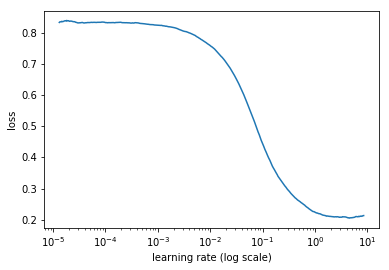

In [36]:
lfr = learn.lr_find()
learn.sched.plot()

* Interestingly, this dataset supports much higher learning rates:

In [37]:
lr = 0.2

In [38]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.147237   0.135807   0.880246  
    1      0.141625   0.128843   0.887508                    
    2      0.13774    0.127698   0.887972                    
    3      0.143787   0.126373   0.890544                    
    4      0.133645   0.123793   0.894234                    
    5      0.129382   0.123025   0.893115                    
    6      0.132338   0.122867   0.893215                    



[0.1228669, 0.8932151103685789]

* Experimenting with differential learning rates:

In [39]:
lrs = np.array([lr/9, lr/3, lr])

In [40]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.122941   0.109922   0.907653  
    1      0.111883   0.106504   0.911824                    
    2      0.108827   0.102103   0.913123                    
    3      0.109458   0.105413   0.91097                     
    4      0.106978   0.101078   0.914405                    
    5      0.099901   0.09778    0.919508                     
    6      0.099053   0.097475   0.918001                     



[0.09747546, 0.918000719618708]

* Can see the different cycles when plotting the loss:
  * Note that each time it finds something better than the time before.

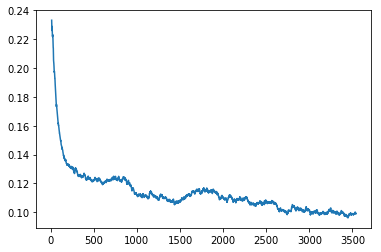

In [41]:
learn.save(f'{sz}')
learn.sched.plot_loss()

* Increase the size a few times:

In [42]:
sz = 128

In [43]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.097504   0.097629   0.915508  
    1      0.096868   0.095777   0.91763                      
    2      0.100454   0.095348   0.917322                     
    3      0.098024   0.094794   0.918653                     
    4      0.098125   0.093727   0.920005                     
    5      0.098589   0.093888   0.919468                     
    6      0.094338   0.092874   0.92027                      



[0.09287422, 0.9202697961118002]

In [ ]:
# Accidentially lost the output of this cell.
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [45]:
learn.save(f'{sz}')

In [47]:
sz = 256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 1/506 [00:02<24:12,  2.88s/it, loss=0.0791]

Exception in thread Thread-43:
Traceback (most recent call last):
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f2                           
    0      0.092918   0.088365   0.924676  
    1      0.08834    0.088782   0.924037                     
    2      0.08779    0.087948   0.924743                     
    3      0.088314   0.087176   0.926117                     
    4      0.088637   0.087977   0.924578                     
    5      0.0863     0.087232   0.92532                      
    6      0.088596   0.087304   0.9255                       



[0.0873043, 0.9254997555888562]

In [48]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.086588   0.082842   0.931132  
    1      0.084058   0.083379   0.93107                      
    2      0.083166   0.082448   0.93122                      
    3      0.084549   0.085384   0.930229                     
    4      0.0836     0.083512   0.930321                     
    5      0.082581   0.081428   0.932636                     
    6      0.078574   0.081367   0.932234                     



[0.08136742, 0.9322341912906509]

In [49]:
learn.save(f'{sz}')

* Now run TTA and calculate the `f2` score:

In [51]:
tta = learn.TTA()

In [68]:
multi_preds, y = tta

In [69]:
preds = np.mean(multi_preds, axis=0)

In [70]:
preds.shape

(8095, 17)

In [71]:
y.shape

(8095, 17)

In [73]:
f2(preds, y)

0.9310704184722481

* Generally wouldn't use a size of 64 if your images are similar to those in ImageNet, since it's so much smaller than the images trained. However, since the satellite data is so different, it can be a good way to avoid overfitting.

## 01:56:26 - Alternatives to Crestle

* Crestle is handy and cheap, but if you want to do more, check out Paperspace.
* Paperspace:
  * Best price / performance ratio.
  
## 01:57:19 - AWS

* AWS credits are in abundance: Github student pack etc.
* Currently have the faster available GPUs: P3s
  * Expensive: \$3 an hour.
* AWS takes some setup.

### 01:59:54 - AWS Setup

* [See this guide](https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/aws_ami_gpu_setup.md) for steps in the video.